In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from helper_functions_from_TSMA import *
import pysam

path_to_bam_file = "/media/hieunguyen/GSHD_HN01/raw_data/bam_files/WGShg19.bam"
path_to_all_fa = "/media/hieunguyen/GSHD_HN01/storage/resources/hg19"
path_to_bed_file = "./methyl_regions/TSMA.bed"

# bedfile = pd.read_csv(path_to_bed_file, sep="\t", header=None)
# bedfile.columns = ["chrom", "start", "end", "region_name"]
# bedfile["region"] = bedfile[["chrom", "start", "end"]].apply(lambda x: "{}:{}-{}".format(x[0], x[1], x[2]), axis=1)

cna_bin = pd.read_csv("./methyl_regions/CNA_bins.bed", header = None)[0].values

outputdf = pd.DataFrame({"CGN_motif": ["CGN", "NCG", "NA"]})
bin = '3:1000001-2000000'
# for bin in tqdm(cna_bin):
readdf = fetch_reads(path_to_bam_file, "chr{}".format(bin))

sampleid = str(path_to_bam_file).split("/")[-1].split(".")[0]

region_chrom = bin.split(":")[0]
region_start = int(bin.split(":")[1].split("-")[0])
region_end = int(bin.split(":")[1].split("-")[1])

refseq_at_cluster = get_refseq(path_to_all_fa = path_to_all_fa, 
                                chrom = region_chrom, 
                                start = region_start, 
                                end = region_end + 1)
all_cpg_in_cluster = [m.start(0) for m in re.finditer("CG", refseq_at_cluster)]
cpg_coords = [item + region_start for item in all_cpg_in_cluster]
cpg_coords_minus1 = [item -1 for item in cpg_coords]

cpg_coords = [str(item) for item in cpg_coords]
cpg_coords_minus1 = [str(item) for item in cpg_coords_minus1]

def assign_status_read_start(x, cpg_coords = cpg_coords, cpg_coords_minus1 = cpg_coords_minus1):
    if x in cpg_coords:
        return "CGN"
    elif x in cpg_coords_minus1:
        return "NCG"
    else:
        return "NA"
readdf["check_CG_motif"] = readdf[["start", "flen"]].apply(lambda x: assign_status_read_start(x[0]) if int(x[1]) > 0 else 
                                                           assign_status_read_start(str(int(x[0]) + 50)), axis = 1)

tmp_outputdf = readdf.groupby("check_CG_motif")["start"].count().reset_index()
tmp_outputdf.columns = ["CGN_motif", bin]
outputdf = outputdf.merge(tmp_outputdf,right_on = "CGN_motif", left_on = "CGN_motif")

/tmp/ipykernel_34363/2511457461.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  readdf["check_CG_motif"] = readdf[["start", "flen"]].apply(lambda x: assign_status_read_start(x[0]) if int(x[1]) > 0 else
/tmp/ipykernel_34363/2511457461.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assign_status_read_start(str(int(x[0]) + 50)), axis = 1)


In [2]:
readdf.groupby("check_CG_motif")["start"].count().reset_index()

,check_CG_motif,start
0,CGN,105
1,NA,9197
2,NCG,37


In [3]:
def get_min_dist_to_cpg(chrom, start, radius = 5):
    refseq_at_cluster = get_refseq(path_to_all_fa = path_to_all_fa, 
                                    chrom = chrom, 
                                    start = start - radius - 1, 
                                    end = start + radius - 1)
    cpg_dists = [m.start(0) - radius for m in re.finditer("CG", refseq_at_cluster)]
    if len(cpg_dists) == 0:
        min_dist_to_cpg = "NA"
    else:
        min_dist_to_cpg = min(cpg_dists)
    return min_dist_to_cpg


In [4]:
# chrom = "18"
# start = 1999507 + 50
# radius = 10
# seq = "GGCAGCTTCCTAATGAGCAATGAATCAGTGACTTGGGCAGAGCTATTTAA"
# refseq_at_cluster = get_refseq(path_to_all_fa = path_to_all_fa, 
#                                     chrom = chrom, 
#                                     start = start - radius - 1, 
#                                     end = start + radius - 1)
# cpg_dists = [m.start(0) - radius for m in re.finditer("CG", refseq_at_cluster)]
# cpg_dists

In [5]:
readdf["mindist"] = readdf[["chrom", "start", "flen"]].apply(lambda x: get_min_dist_to_cpg(x[0].replace("chr", ""), int(x[1])) if int(x[2]) > 0 else 
                                                           get_min_dist_to_cpg(x[0].replace("chr", ""), int(x[1]) + 50), axis = 1)


/tmp/ipykernel_34363/2947069879.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  readdf["mindist"] = readdf[["chrom", "start", "flen"]].apply(lambda x: get_min_dist_to_cpg(x[0].replace("chr", ""), int(x[1])) if int(x[2]) > 0 else
/tmp/ipykernel_34363/2947069879.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_min_dist_to_cpg(x[0].replace("chr", ""), int(x[1]) + 50), axis = 1)


<Axes: xlabel='dist', ylabel='freq'>

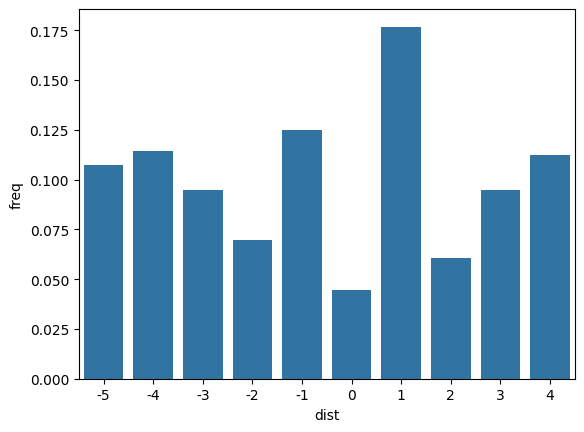

In [6]:
plotdf = readdf[readdf["mindist"] != "NA"].groupby("mindist")["start"].count().reset_index()
plotdf.columns = ["dist", "count"]
plotdf["freq"] = plotdf["count"] / plotdf["count"].sum()
sns.barplot(data = plotdf, x = "dist", y = "freq")